<h1> Multivariate Time Series Analysis using LSTM <h1>

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

PATH = "./2023-stuard/"
COLORS = ["#2c2a4a", "#4f518c", "#907ad6", "#dabfff"]

<h2> Dataset Creation <h2>


Sensor Data:<br><br>
- Volumetric Water Content of Teros 12 number 2 (VWC_1)
- Temperature (T_1)
- Eletrical Conductivity (EC_1)
<br><br>
Thesis 2 -->> 60 % IRRFRAME, *TEROS 12* at 15 cm

,soil_vwc,soil_temperature,soil_ec
timestamp,,,
2023-07-11 10:10:00,0.293157,29.03,0.554626
2023-07-11 10:20:00,0.294282,27.98,0.571479
2023-07-11 10:30:00,0.294709,27.49,0.579429
2023-07-11 10:40:00,0.295174,27.21,0.583445
2023-07-11 10:50:00,0.295291,27.04,0.58479
...,...,...,...
2023-09-19 23:10:00,0.287726,25.3,0.533335
2023-09-19 23:20:00,0.287688,25.3,0.533335
2023-09-19 23:30:00,0.287726,25.29,0.533335


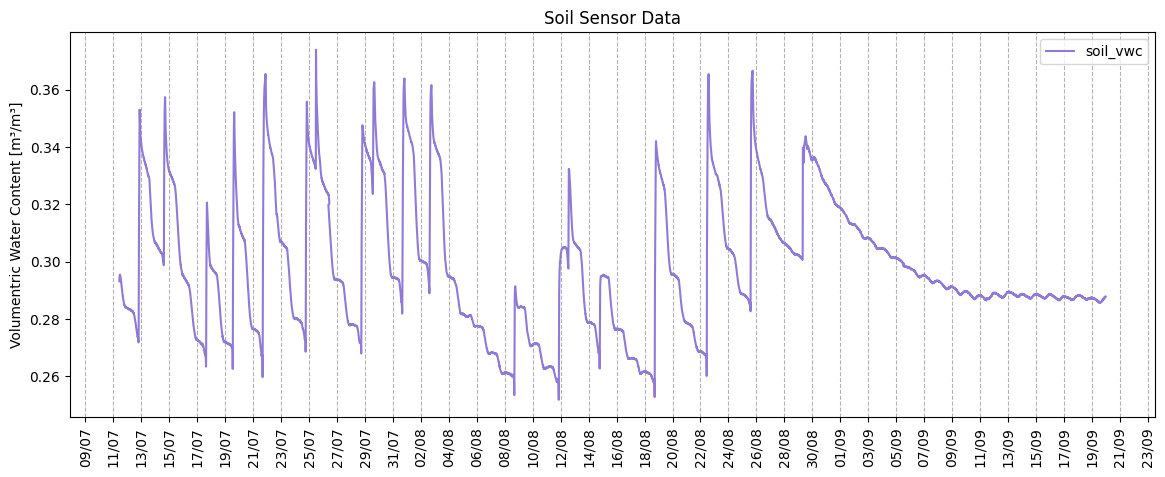

In [2]:
df_sensor = pd.read_excel(PATH + "z6-06728 20set23-1604.xlsx")
# drop columns with non relevant data for this analysis
df_sensor.drop(columns=["Port 2", "Port 2.1", "Port 2.2", "Port 3", "Port 3.1",
                        "Port 3.2", "Port 4", "Port 4.1", "Port 4.2", "Port 7",
                        "Port 7.1", "Port 8", "Port 8.1"], inplace=True)
# rename columns
df_sensor = df_sensor.rename(
    columns={
        "z6-06728": "timestamp",
        "Port 1": "soil_vwc",
        "Port 1.1": "soil_temperature",
        "Port 1.2": "soil_ec",
    }
)
# drop first 2 rows
df_sensor = df_sensor.iloc[2:, :]

# apply timezone
df_sensor["timestamp"] = df_sensor["timestamp"].apply(
    lambda x: x + datetime.timedelta(hours=2))

# remove data after 20th September
df_sensor = df_sensor.loc[df_sensor["timestamp"]
                          < datetime.datetime(2023, 9, 20)]

df_sensor.set_index("timestamp", inplace=True)

# plot Volumentric Water Content from sensors
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_sensor.index, df_sensor["soil_vwc"], label="soil_vwc", color=COLORS[2], zorder=2)
ax.set_ylabel("Volumentric Water Content [m³/m³]")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)
ax.legend()
ax.set_title("Soil Sensor Data")
df_sensor

## Weather Station Data 
Precipitations and other features related to weather

In [3]:
# PRECIPITATIONS measurements in Stuard, San Pancrazio

# concatenate data from all June to September files
df_weatherinfo = pd.concat([
    pd.read_csv(PATH + "SANPANCRAZIO2023-06.csv"),
    pd.read_csv(PATH + "SANPANCRAZIO2023-07.csv"),
    pd.read_csv(PATH + "SANPANCRAZIO2023-08.csv"),
    pd.read_csv(PATH + "SANPANCRAZIO2023-09.csv"),
])

df_weatherinfo = df_weatherinfo[[
    "date",
    "global_radiation_flux",
    "temperature",
    "relative_humidity",
    "precipitation",
    "wind_speed",
]]

# convert date to timestamp
df_weatherinfo["timestamp"] = pd.to_datetime(df_weatherinfo["date"]).dt.tz_localize(None)
df_weatherinfo.drop(columns=["date"], inplace=True)
df_weatherinfo.set_index("timestamp", inplace=True)

# set index using date_range
df_weatherinfo = df_weatherinfo.reindex(
    pd.date_range(start="2023-06-01 00:00", end="2023-09-30 23:45", freq="15min"))

# find lines with missing data
missing_data = df_weatherinfo.isnull().sum(axis=1)
missing_data = missing_data[missing_data > 0]
missing_data

2023-06-04 13:00:00    5
2023-06-08 08:15:00    5
2023-06-16 17:00:00    5
2023-06-18 22:00:00    5
2023-06-19 18:30:00    5
                      ..
2023-09-15 10:00:00    5
2023-09-20 09:15:00    1
2023-09-20 09:30:00    1
2023-09-20 09:45:00    1
2023-09-20 10:00:00    1
Length: 80, dtype: int64

In [4]:
# fill missing data with linear interpolation (for all the features)
df_weatherinfo = df_weatherinfo.interpolate()

# example interpolation for sample "2023-06-04 13:00:00"
df_weatherinfo['2023-06-04 12:00:00':'2023-06-04 14:00:00']


,global_radiation_flux,temperature,relative_humidity,precipitation,wind_speed
2023-06-04 12:00:00,475.0,297.850,62.0,0.0,1.8
2023-06-04 12:15:00,953.0,298.390,60.0,0.0,2.0
2023-06-04 12:30:00,930.0,298.800,57.0,0.0,2.3
2023-06-04 12:45:00,658.0,298.830,56.0,0.0,1.6
2023-06-04 13:00:00,442.5,298.335,57.5,0.0,1.7
2023-06-04 13:15:00,227.0,297.840,59.0,0.0,1.8
2023-06-04 13:30:00,191.0,297.710,60.0,0.0,1.9
2023-06-04 13:45:00,226.0,297.790,60.0,0.0,1.4
2023-06-04 14:00:00,299.0,298.120,59.0,0.0,1.2


In [5]:
# convert temperature to Celsius
df_weatherinfo["temperature"] = df_weatherinfo["temperature"] - 273.15

# upsample to 5 minutes using linear interpolation for all features,
# and then dividing precipitation by 3
df_weatherinfo = df_weatherinfo.resample("5min").interpolate()
df_weatherinfo["precipitation"] = df_weatherinfo["precipitation"] / 3

# downsample to 10 minutes using mean for radiation, temperature, humidity and
# wind speed, while summing precipitation
df_weatherinfo = df_weatherinfo.resample("10min").agg(
    {
        "global_radiation_flux": "mean",
        "temperature": "mean",
        "relative_humidity": "mean",
        "precipitation": "sum",
        "wind_speed": "mean",
    }
)

df_weatherinfo

,global_radiation_flux,temperature,relative_humidity,precipitation,wind_speed
2023-06-01 00:00:00,0.0,14.238333,92.000000,0.0,0.450000
2023-06-01 00:10:00,0.0,13.871667,92.000000,0.0,0.650000
2023-06-01 00:20:00,0.0,13.650000,93.500000,0.0,0.850000
2023-06-01 00:30:00,0.0,13.515000,95.166667,0.0,1.083333
2023-06-01 00:40:00,0.0,13.495000,95.833333,0.0,1.416667
...,...,...,...,...,...
2023-09-30 23:00:00,0.0,18.881667,66.000000,0.0,2.350000
2023-09-30 23:10:00,0.0,18.848333,66.000000,0.0,2.150000
2023-09-30 23:20:00,0.0,18.765000,66.000000,0.0,2.100000
2023-09-30 23:30:00,0.0,18.666667,66.166667,0.0,2.050000


## Irrigation

Getting Irrigation data<br>
**NOTE: Using only T2 (60% of IRRIFRAME)**

,irrigation
timestamp,
2023-07-10 00:00:00,0.0
2023-07-10 00:10:00,0.0
2023-07-10 00:20:00,0.0
2023-07-10 00:30:00,0.0
2023-07-10 00:40:00,0.0
...,...
2023-09-19 23:20:00,0.0
2023-09-19 23:30:00,0.0
2023-09-19 23:40:00,0.0


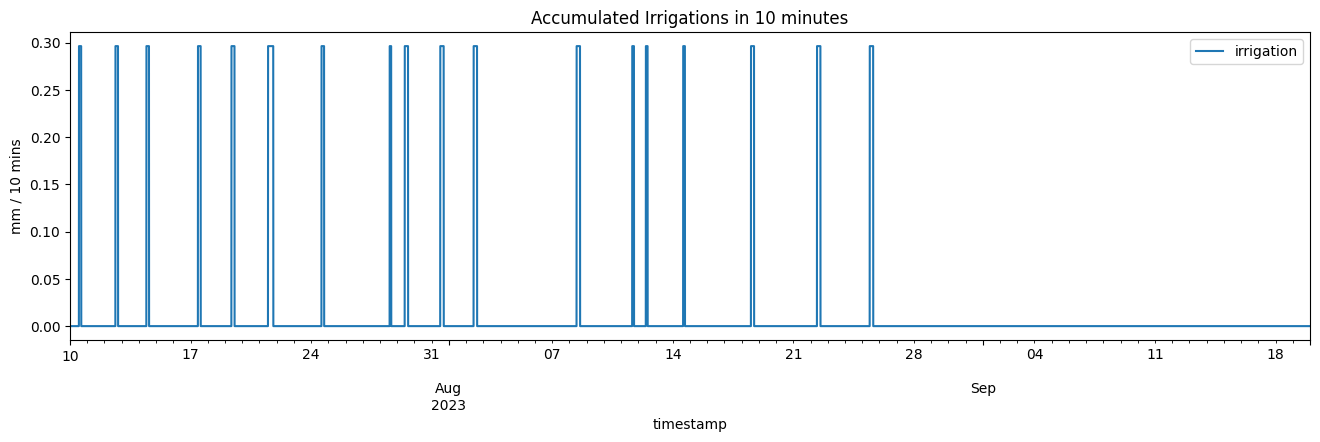

In [6]:
df_irrigations = pd.read_csv(PATH + "irrigazioniStuard2023.csv")
df_irrigations = pd.DataFrame(
    {
        "start": pd.to_datetime(
            df_irrigations["Data"].astype(str)
            + " "
            + df_irrigations["Ora inizio irrigazione (tutte le tesi)"].fillna("00:00"),
            format="%Y-%m-%d %H:%M",
        ),
        "t2_irrigation": df_irrigations["T2 - Volume idrico (mm)"],
        "t2_duration": df_irrigations["T2 - Ore irrigazione (n° ore)"],
    }
)
df_irrigations["t2_end"] = df_irrigations["start"] + pd.to_timedelta(
    df_irrigations["t2_duration"], unit="h"
)

# create time series
ts_irrigations = pd.DataFrame(
    index=pd.date_range(start="2023-07-10", end="2023-09-20", freq="10min")
)
VOLUME_IDRICO_ORARIO = 1.778  # mm/h
ts_irrigations["t2"] = 0.0
for i, row in df_irrigations[df_irrigations["start"] > "2023-07-10"].iterrows():
    ts_irrigations.loc[row["start"] : row["t2_end"], "t2"] = VOLUME_IDRICO_ORARIO / 6

ts_irrigations.reset_index(inplace=True)
ts_irrigations.rename(columns={"index": "timestamp", "t2": "irrigation"}, inplace=True)
ts_irrigations.set_index("timestamp", inplace=True)

ts_irrigations.plot(title="Accumulated Irrigations in 10 minutes", ylabel="mm / 10 mins", figsize=(16, 4))
ts_irrigations

## Merge Dataset
Putting all data toghether in the same dataframe to get the multivariate dataset

In [7]:
# Merge dataframes
df = pd.merge(df_sensor, df_weatherinfo, left_index=True, right_index=True, how="left")
df = pd.merge(df, ts_irrigations, left_index=True, right_index=True, how="left")

# make sure that the values are ordered by timestamp
df.sort_index(inplace=True)

df

,soil_vwc,soil_temperature,soil_ec,global_radiation_flux,temperature,relative_humidity,precipitation,wind_speed,irrigation
timestamp,,,,,,,,,
2023-07-11 10:10:00,0.293157,29.03,0.554626,836.000000,32.591667,50.000000,0.0,2.166667,0.0
2023-07-11 10:20:00,0.294282,27.98,0.571479,845.500000,32.905000,49.000000,0.0,2.050000,0.0
2023-07-11 10:30:00,0.294709,27.49,0.579429,853.833333,33.266667,47.666667,0.0,2.050000,0.0
2023-07-11 10:40:00,0.295174,27.21,0.583445,861.166667,33.533333,46.333333,0.0,2.250000,0.0
2023-07-11 10:50:00,0.295291,27.04,0.58479,862.500000,33.700000,45.500000,0.0,2.000000,0.0
...,...,...,...,...,...,...,...,...,...
2023-09-19 23:10:00,0.287726,25.3,0.533335,0.000000,19.826667,61.500000,0.0,2.183333,0.0
2023-09-19 23:20:00,0.287688,25.3,0.533335,0.000000,19.565000,63.000000,0.0,2.700000,0.0
2023-09-19 23:30:00,0.287726,25.29,0.533335,0.000000,19.391667,63.833333,0.0,3.216667,0.0


In [8]:
# check for missing values
df.isnull().sum()

soil_vwc                 0
soil_temperature         0
soil_ec                  0
global_radiation_flux    0
temperature              0
relative_humidity        0
precipitation            0
wind_speed               0
irrigation               0
dtype: int64

## Normalizing and Scaling data

Scaling data with StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler

# standardize data
standardizer = StandardScaler()
df_scaled = pd.DataFrame(
    standardizer.fit_transform(df.to_numpy()),
    columns=df.columns,
    index=df.index,
)
df_scaled

,soil_vwc,soil_temperature,soil_ec,global_radiation_flux,temperature,relative_humidity,precipitation,wind_speed,irrigation
timestamp,,,,,,,,,
2023-07-11 10:10:00,-0.211271,2.944592,-0.568325,1.999911,1.385843,-0.390676,-0.055964,0.000907,-0.209808
2023-07-11 10:20:00,-0.162457,2.302322,-0.446523,2.031956,1.446383,-0.447417,-0.055964,-0.095991,-0.209808
2023-07-11 10:30:00,-0.143942,2.002596,-0.389065,2.060065,1.516262,-0.523072,-0.055964,-0.095991,-0.209808
2023-07-11 10:40:00,-0.123743,1.831324,-0.360037,2.084801,1.567786,-0.598727,-0.055964,0.070119,-0.209808
2023-07-11 10:50:00,-0.118693,1.727337,-0.350317,2.089298,1.599988,-0.646012,-0.055964,-0.137518,-0.209808
...,...,...,...,...,...,...,...,...,...
2023-09-19 23:10:00,-0.446924,0.663004,-0.722202,-0.819997,-1.080532,0.261849,-0.055964,0.014749,-0.209808
2023-09-19 23:20:00,-0.448607,0.663004,-0.722202,-0.819997,-1.131089,0.346961,-0.055964,0.443866,-0.209808
2023-09-19 23:30:00,-0.446924,0.656887,-0.722202,-0.819997,-1.164580,0.394246,-0.055964,0.872984,-0.209808


# Feature Analysis
The focus is on the Volumetric Water Content, so soil_vwc is the target and the other 8 columns are classified as features

In [10]:
# Performing feature selection with filter methods
from sklearn.feature_selection import mutual_info_regression

# Splitting data in features and target (soil_vwc)
X_sel = df.drop(columns=["soil_vwc"])
y_sel = df["soil_vwc"]

# 1) MUTUAL INFORMATION 
# Applying mutual information and visualizing the results to istant data
mi = mutual_info_regression(X_sel, y_sel)
mi_scores = pd.Series(mi, index = X_sel.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

soil_ec                  2.534775
soil_temperature         1.277580
relative_humidity        0.592105
temperature              0.555520
wind_speed               0.194187
global_radiation_flux    0.164593
irrigation               0.043867
precipitation            0.022293
dtype: float64

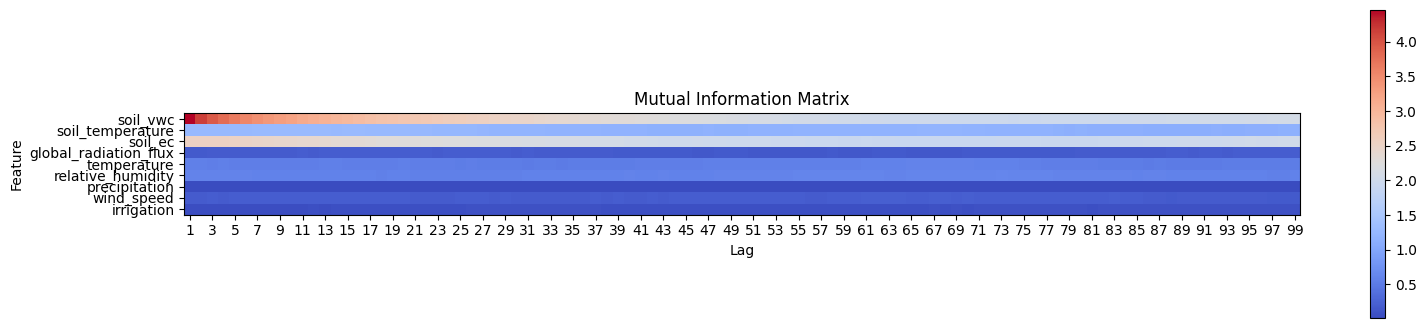

In [11]:
# Applying mutual information and visualizing the results to lagged data

pd.set_option('future.no_silent_downcasting', True)
# Splitting data in features and target (soil_vwc)
X_sel = df

# plot a matrix of mutual information using different lags
lags = range(1, 100)
mi_scores_lags = pd.DataFrame()
for lag in lags:
    y_sel = df['soil_vwc'].shift(-lag).fillna(0)
    mi = mutual_info_regression(X_sel, y_sel)
    mi_scores = pd.Series(mi, index=X_sel.columns)
    mi_scores_lags[lag] = mi_scores

fig, ax = plt.subplots(figsize=(18, 4))
cax = ax.matshow(mi_scores_lags, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xlabel('Lag')
ax.set_xticks(range(0, len(lags), 2))
ax.set_xticklabels(lags[::2])
ax.xaxis.tick_bottom()
ax.set_ylabel('Feature')
ax.set_yticks(range(df.shape[1]))
ax.set_yticklabels(df.columns)
ax.set_title('Mutual Information Matrix')
plt.show()

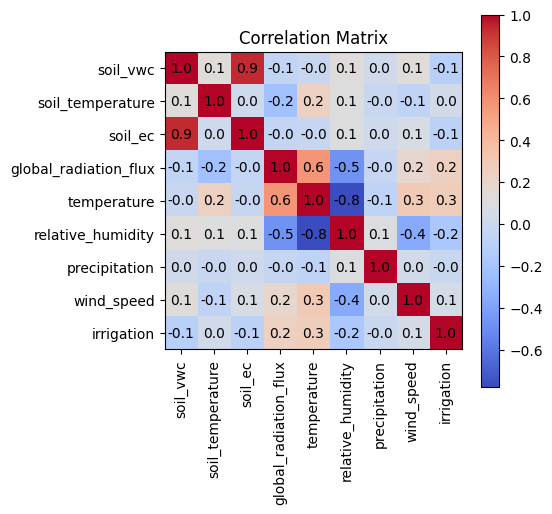

In [12]:
# 2) Pearson Correlation
# Applying Pearson Correlation and visualizing the results in matrix form
plt.matshow(df.corr(method='pearson'), cmap='coolwarm')
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df.shape[1]), df.columns)
for (i, j), val in np.ndenumerate(df.corr()):
    plt.text(j, i, '{:0.1f}'.format(val), ha='center', va='center')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

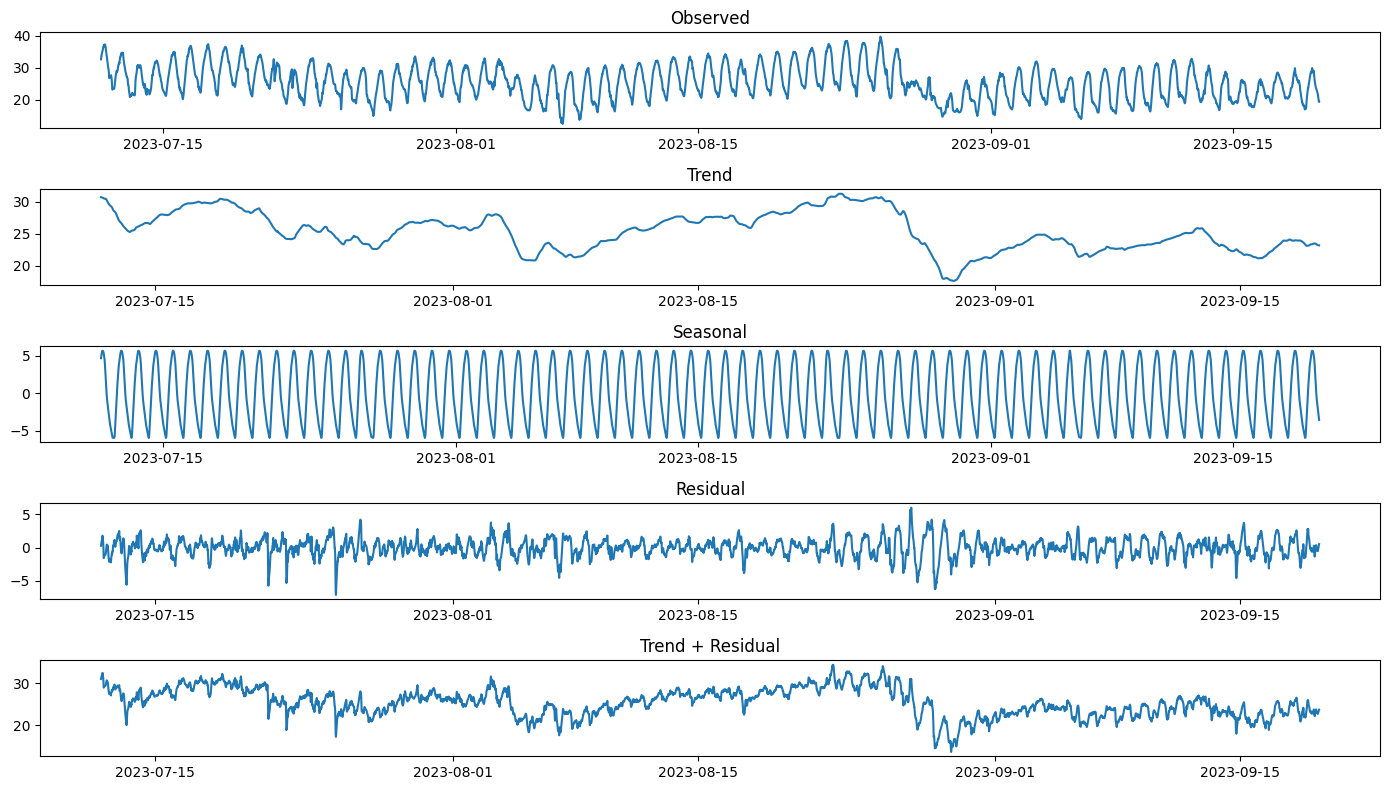

In [13]:
import statsmodels.api as sm

# Sample seasonal time series data
# period is daily
seasonal_data = sm.tsa.seasonal_decompose(df['temperature'], model='additive', period=6*24)

# plot components
fig, ax = plt.subplots(5, 1, figsize=(14, 8))
ax[0].plot(seasonal_data.observed)
ax[0].set_title('Observed')
ax[1].plot(seasonal_data.trend)
ax[1].set_title('Trend')
ax[2].plot(seasonal_data.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(seasonal_data.resid)
ax[3].set_title('Residual')
ax[4].plot(seasonal_data.trend + seasonal_data.resid)
ax[4].set_title('Trend + Residual')
plt.tight_layout()
plt.show()

## Creating "new" features

<Axes: title={'center': '24h Rolling Sum of Precipitation'}, xlabel='timestamp'>

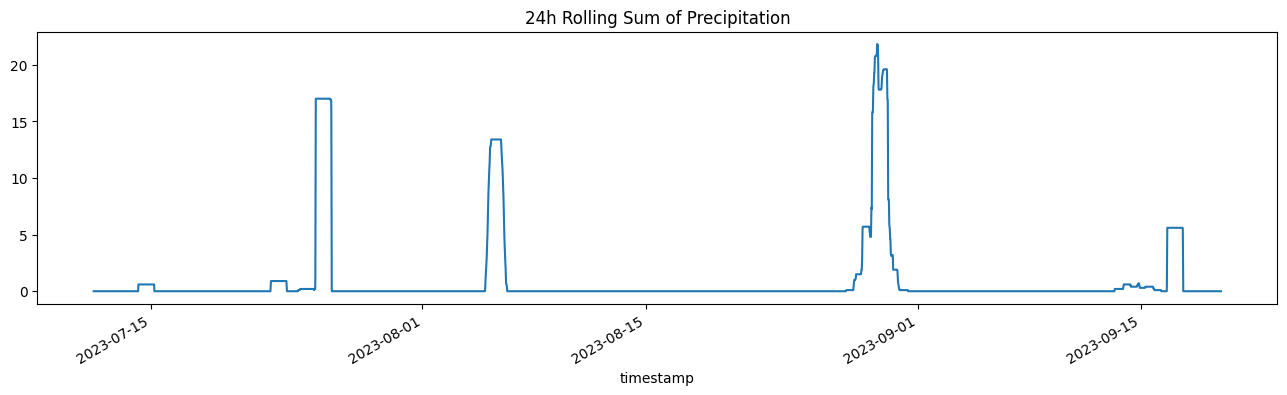

In [14]:
# Example -->> Sum of 24h precipitations
df['precipitation'].rolling('24h').sum().plot(title='24h Rolling Sum of Precipitation', figsize=(16, 4))

In [15]:
# remove seasonality from temperature, humidity and solar radiation
for feature in ['temperature', 'relative_humidity', 'global_radiation_flux']:
    seasonal_data = sm.tsa.seasonal_decompose(df[feature], model='additive', period=6*24)
    df[feature + '_ds'] = df[feature] - seasonal_data.seasonal

# sum toghether precipitation and irrigation since they represent the same phenomenon
df['water'] = df['precipitation'] + df['irrigation']

# aggregate water (precipitation and irrigation) using different time windows
df['water_01h'] = df[feature].rolling('1h').sum()
df['water_03h'] = df[feature].rolling('3h').sum()
df['water_06h'] = df[feature].rolling('6h').sum()
df['water_12h'] = df[feature].rolling('12h').sum()
df['water_24h'] = df[feature].rolling('24h').sum()
df['water_36h'] = df[feature].rolling('36h').sum()
df['water_48h'] = df[feature].rolling('48h').sum()
df['water_72h'] = df[feature].rolling('72h').sum()

# aggregate temperature, humidity and solar radiation using different time windows
for feature in ['temperature_ds', 'relative_humidity_ds', 'global_radiation_flux_ds']:
    df[feature + '_01h'] = df[feature].rolling('1h').mean()
    df[feature + '_03h'] = df[feature].rolling('3h').mean()
    df[feature + '_06h'] = df[feature].rolling('6h').mean()
    df[feature + '_12h'] = df[feature].rolling('12h').mean()
    df[feature + '_24h'] = df[feature].rolling('24h').mean()
    df[feature + '_36h'] = df[feature].rolling('36h').mean()
    df[feature + '_48h'] = df[feature].rolling('48h').mean()
    df[feature + '_72h'] = df[feature].rolling('72h').mean()

# sort columns
df = df.reindex(sorted(df.columns), axis=1)

df.describe()

,global_radiation_flux,global_radiation_flux_ds,global_radiation_flux_ds_01h,global_radiation_flux_ds_03h,global_radiation_flux_ds_06h,global_radiation_flux_ds_12h,global_radiation_flux_ds_24h,global_radiation_flux_ds_36h,global_radiation_flux_ds_48h,global_radiation_flux_ds_72h,...,water,water_01h,water_03h,water_06h,water_12h,water_24h,water_36h,water_48h,water_72h,wind_speed
count,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,...,10151.000000,10151.000000,10151.000000,10151.000000,10151.00000,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000
mean,243.099153,243.383332,243.338561,243.352725,243.481469,243.970709,245.033092,245.855955,246.889776,248.393243,...,0.018819,1484.206252,4431.870620,8823.561472,17549.64845,34765.872196,52109.122426,69292.244212,103579.422093,2.165575
std,296.478166,111.271394,106.534919,99.003397,89.967042,77.032110,64.843976,62.436714,59.253395,55.599429,...,0.127126,1831.749778,5223.823011,9333.263230,13023.15800,8706.510261,17234.695370,15932.785459,23129.940335,1.204082
min,0.000000,-444.411158,-435.224299,-405.586532,-314.213055,-129.704973,52.187500,56.078232,98.844907,96.809028,...,0.000000,0.000000,0.000000,0.000000,6.50000,836.000000,836.000000,836.000000,836.000000,0.116667
25%,0.000000,236.813524,236.847097,234.678769,231.837606,223.032757,223.833333,220.202029,223.363715,226.336323,...,0.000000,0.000000,0.000000,221.750000,5125.75000,31134.750000,39604.750000,62605.500000,94024.500000,1.350000
50%,69.500000,242.858501,242.956223,242.899685,242.801496,247.968862,255.799769,254.458475,255.800347,256.467014,...,0.000000,440.000000,1653.000000,5058.000000,16230.75000,36262.083333,50614.750000,72852.250000,107481.666667,1.933333
75%,496.916667,285.384616,283.467063,280.732245,279.601595,280.979230,283.693113,282.651119,283.075521,282.347222,...,0.000000,2967.250000,8714.250000,16671.000000,28915.50000,40708.000000,65586.750000,81138.000000,120832.125000,2.600000
max,1008.000000,696.665241,690.862160,668.334718,616.207719,573.367946,573.367946,573.367946,573.367946,573.367946,...,6.733333,10527.000000,25581.500000,39693.500000,55324.50000,56751.166667,98892.500000,100299.500000,141683.833333,8.850000


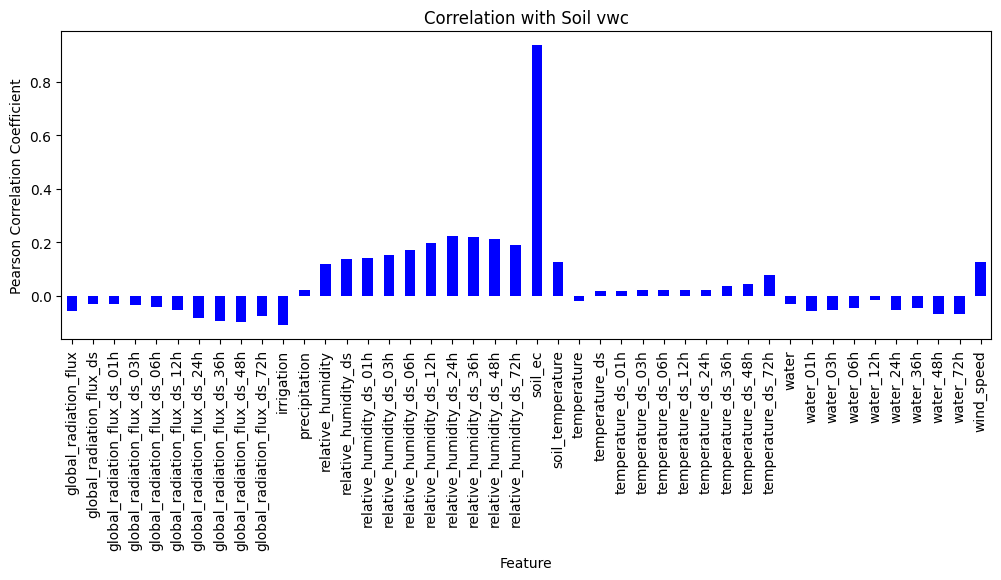

soil_ec                     0.936327
relative_humidity_ds_24h    0.223776
relative_humidity_ds_36h    0.220843
relative_humidity_ds_48h    0.214058
relative_humidity_ds_12h    0.197441
relative_humidity_ds_72h    0.191574
relative_humidity_ds_06h    0.170568
relative_humidity_ds_03h    0.151596
relative_humidity_ds_01h    0.140801
relative_humidity_ds        0.136820
Name: soil_vwc, dtype: float64

In [16]:
# Bar graph of correlation Pearson scores with soil_vwc
correlation_scores = df.corr()['soil_vwc'].drop('soil_vwc') 
plt.figure(figsize=(12, 4))
correlation_scores.plot(kind='bar', color='blue', legend=False)
plt.title('Correlation with Soil vwc')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Feature')
plt.show()

# Top 10 Correlation scores
correlation_scores.sort_values(ascending=False).head(10)

global_radiation_flux_ds_72h    2.356738
temperature_ds_72h              2.355619
water_72h                       2.334657
global_radiation_flux_ds_48h    2.293344
water_48h                       2.283297
temperature_ds_48h              2.275807
temperature_ds_36h              2.164719
global_radiation_flux_ds_24h    2.163548
water_24h                       2.149544
temperature_ds_24h              2.098411
relative_humidity_ds_72h        2.050296
relative_humidity_ds_48h        2.001584
relative_humidity_ds_36h        1.846787
relative_humidity_ds_24h        1.762073
global_radiation_flux_ds_36h    1.618311
dtype: float64

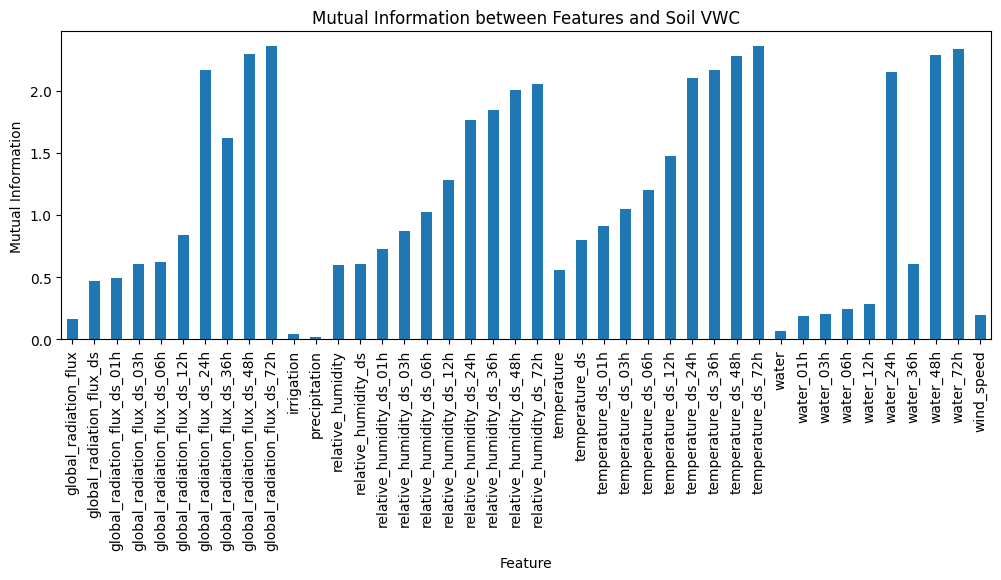

In [17]:
# Applying mutual correlation and obteining scores with soil_vwc
X_sel = df
y_sel = df['soil_vwc']
mi = mutual_info_regression(X_sel, y_sel)
mi_scores = pd.Series(mi, index=X_sel.columns)
mi_scores.drop(['soil_vwc', 'soil_ec', 'soil_temperature'], inplace=True)
mi_scores.plot(
    kind='bar',
    title='Mutual Information between Features and Soil VWC',
    figsize=(12, 4),
    xlabel='Feature',
    ylabel='Mutual Information',
)

mi_scores.sort_values(ascending=False).head(15)

## Timeseries Analysis
Timeseries analysis using *mutual information* on different lags and *autocorrelation* plot, considering also all the new features

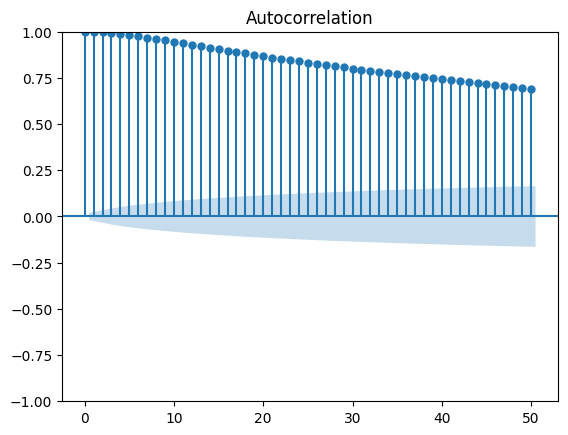

In [18]:
# Autocorrelation plot of soil_vwc -->> Checks the influence of the previous values on the current value of the target variable
from statsmodels.graphics.tsaplots import plot_acf

time_series = df_scaled['soil_vwc']
plot_acf(time_series, lags=50)
plt.show()

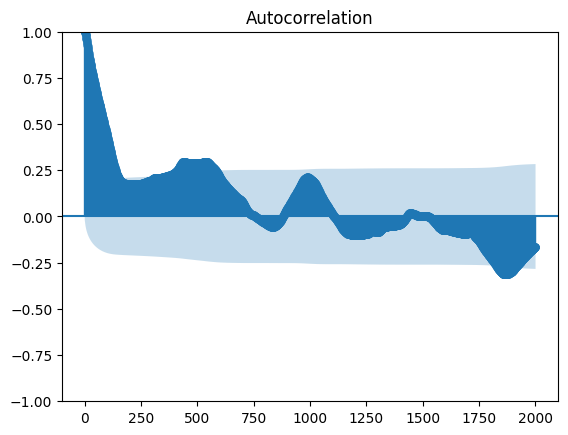

In [19]:
plot_acf(time_series, lags=2000)
plt.show()

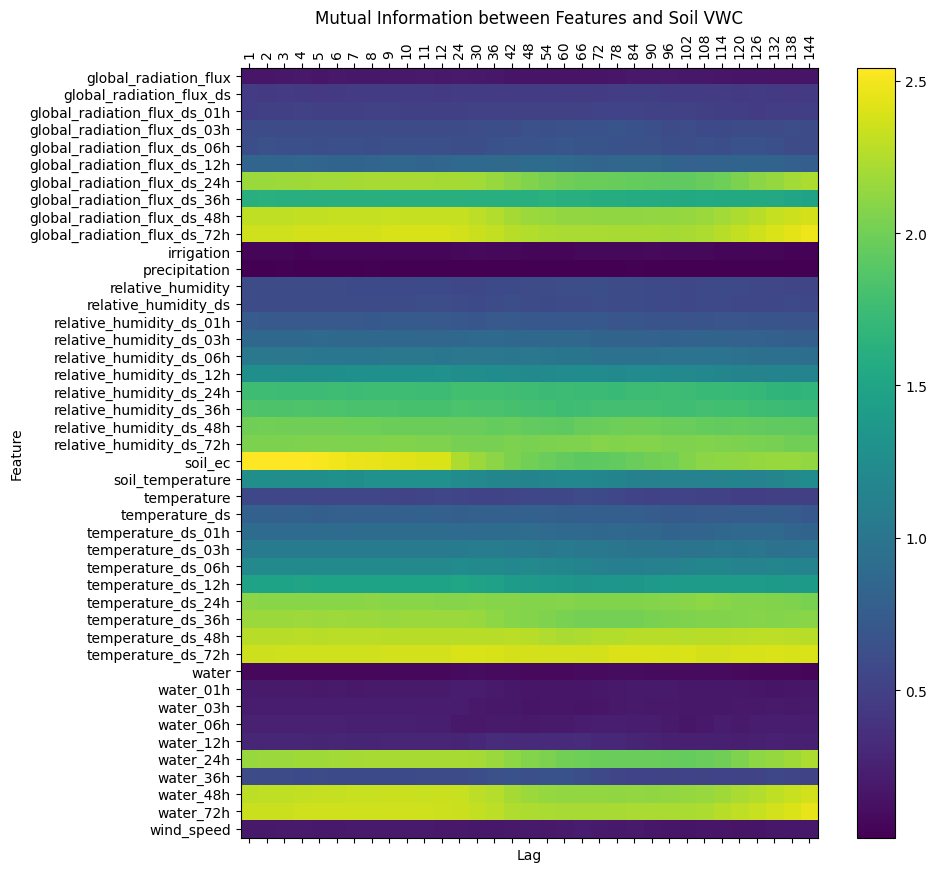

In [20]:
# Correlation Plot of soil_vwc with lagged values -->> Checks the influence of the previous values features on the current value of the target variable
# Splitting data in features and target (soil_vwc)
X_sel = df.drop(columns=['soil_vwc'])

# plot a matrix of mutual information using lags from 1 to 144 (24h)
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 30, 36, 42, 48, 54,
        60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144]
mi_scores_lags = pd.DataFrame()
for lag in lags:
    y_sel = df['soil_vwc'].shift(-lag).fillna(0)
    mi = mutual_info_regression(X_sel, y_sel)
    mi_scores = pd.Series(mi, index=X_sel.columns)
    mi_scores_lags[lag] = mi_scores

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(mi_scores_lags)
fig.colorbar(cax)
ax.set_xlabel('Lag')
ax.set_xticks(range(len(lags)))
ax.set_xticklabels(lags)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Feature')
ax.set_yticks(range(X_sel.shape[1]))
ax.set_yticklabels(X_sel.columns)
ax.set_title('Mutual Information between Features and Soil VWC')
plt.show()

Creating a dataset df_best with 10 of the best perfoming features basing on previous feature selection analysis

In [21]:
mi_scores.drop(['soil_ec', 'soil_temperature'], inplace=True)
mi_scores.sort_values(ascending=False).head(10)

global_radiation_flux_ds_72h    2.476571
water_72h                       2.446265
temperature_ds_72h              2.397972
global_radiation_flux_ds_48h    2.384354
water_48h                       2.366869
temperature_ds_48h              2.274209
global_radiation_flux_ds_24h    2.232742
water_24h                       2.231992
temperature_ds_36h              2.094657
temperature_ds_24h              2.035190
dtype: float64

In [22]:
df_best1 = df[['soil_vwc', 'global_radiation_flux_ds_72h', 'water_72h', 'temperature_ds_72h', 'global_radiation_flux_ds_48h', 'water_48h', 'temperature_ds_48h',
                'global_radiation_flux_ds_24h', 'water_24h', 'temperature_ds_36h', 'temperature_ds_24h']]

# Insert here new dataset with the best features, if needed

# Scaling data
# standardize data
standardizer = StandardScaler()
df_best1_scaled = pd.DataFrame(
    standardizer.fit_transform(df_best1.to_numpy()),
    columns=df_best1.columns,
    index=df_best1.index,
)
df_best1_scaled

,soil_vwc,global_radiation_flux_ds_72h,water_72h,temperature_ds_72h,global_radiation_flux_ds_48h,water_48h,temperature_ds_48h,global_radiation_flux_ds_24h,water_24h,temperature_ds_36h,temperature_ds_24h
timestamp,,,,,,,,,,,
2023-07-11 10:10:00,-0.211271,2.357551,-4.442229,0.850424,2.237543,-4.296776,0.838971,2.073266,-3.897261,0.834509,0.833888
2023-07-11 10:20:00,-0.162457,2.483610,-4.405672,0.884035,2.355829,-4.243707,0.871565,2.181353,-3.800145,0.866583,0.865572
2023-07-11 10:30:00,-0.143942,2.614781,-4.368756,0.924253,2.478911,-4.190115,0.910567,2.293824,-3.702072,0.904963,0.903486
2023-07-11 10:40:00,-0.123743,2.790633,-4.331523,0.958531,2.643918,-4.136062,0.943808,2.444605,-3.603156,0.937674,0.935800
2023-07-11 10:50:00,-0.118693,2.952094,-4.294231,0.985525,2.795422,-4.081926,0.969985,2.583047,-3.504088,0.963433,0.961247
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19 23:10:00,-0.446924,-1.794187,-1.702030,-0.664027,-1.826008,-1.842031,-0.674240,-0.798619,-0.796900,-0.736295,-0.751437
2023-09-19 23:20:00,-0.448607,-1.794187,-1.702030,-0.665409,-1.826008,-1.842031,-0.677166,-0.798619,-0.796900,-0.734416,-0.752926
2023-09-19 23:30:00,-0.446924,-1.794187,-1.702030,-0.666947,-1.826008,-1.842031,-0.679962,-0.798619,-0.796900,-0.732932,-0.754253


Saving the dataset to be used in the lstm project

In [23]:
df_best1_scaled.to_excel("./2023-stuard/df_best_scaled.xlsx", index=True)